In [58]:
# Importing Required Libraries
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import seaborn as sns
import warnings
import pandas as pd
%matplotlib inline
warnings.filterwarnings('ignore')

In [59]:
df = pd.read_csv(r"Dataset.csv")
df.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


## Data Preprocessing

In [60]:
df.isnull().sum()

name            0
club            0
age             0
position        0
position_cat    0
market_value    0
page_views      0
fpl_value       0
fpl_sel         0
fpl_points      0
region          1
nationality     0
new_foreign     0
age_cat         0
club_id         0
big_club        0
new_signing     0
dtype: int64

In [61]:
# Imputing the missing value of region record as the most common value
df['region'] = df['region'].fillna(2.)

In [63]:
class DataPreprocessing:
    def __init__(self,data):
        
        self.data = df
        # self.cols_to_be_dropped = ['name','club_id','age_cat','nationality']
        self.cols_to_be_encoded = ['club','position','position_cat','region']
        
    def addPosCat(self,inputCat):

        if inputCat == 1:
            return('Attackers')
        elif inputCat == 2:
            return('Midfielders')
        elif inputCat == 3:
            return('Defenders')
        else:
            return('Goalkeeper')
        
    def addRegion(self, inpregion):
    
        if inpregion == 1:
            return('England')
        elif inpregion == 2:
            return('EU')
        elif inpregion == 3:
            return('Americans')
        else:
            return('Rest of World')
        
    def columnTypeConversion(self):
        
        # Converting fpl selection into numeric variable 
        self.data['fpl_sel'] = self.data['fpl_sel'].map(lambda x: str(x)[:-1]).astype('float')
        
    def logTransformation(self):
        
        # log transformation on page views variable as it has a high skew
        self.data['page_views'] = self.data['page_views'].apply(np.log)
        
    # Encoding the categorical variables using pandas dummies 
    def dataEncoding(self):

        self.data = pd.get_dummies(self.data, columns = self.cols_to_be_encoded, drop_first = True)
        
    def getProcessedData(self):
        # self.data = self.data.drop(self.cols_to_be_dropped, inplace = False, axis = 1)
        self.data['position_cat'] = self.data['position_cat'].apply(self.addPosCat)
        self.data['region'] = self.data['region'].apply(self.addRegion)
        self.columnTypeConversion()
        self.dataEncoding()
        self.logTransformation()
        return self.data

In [64]:
data_obj = DataPreprocessing(df) 
encoded_data = data_obj.getProcessedData()
encoded_data.head()

,name,age,market_value,page_views,fpl_value,fpl_sel,fpl_points,nationality,new_foreign,age_cat,...,position_RB,position_RM,position_RW,position_SS,position_cat_Defenders,position_cat_Goalkeeper,position_cat_Midfielders,region_EU,region_England,region_Rest of World
0,Alexis Sanchez,28,65.0,8.373092,12.0,17.1,264,Chile,0,4,...,0,0,0,0,0,0,0,0,0,0
1,Mesut Ozil,28,50.0,8.388223,9.5,5.6,167,Germany,0,4,...,0,0,0,0,0,0,0,1,0,0
2,Petr Cech,35,7.0,7.332369,5.5,5.9,134,Czech Republic,0,6,...,0,0,0,0,0,1,0,1,0,0
3,Theo Walcott,28,20.0,7.780303,7.5,1.5,122,England,0,4,...,0,0,1,0,0,0,0,0,1,0
4,Laurent Koscielny,31,22.0,6.815640,6.0,0.7,121,France,0,4,...,0,0,0,0,1,0,0,1,0,0


# 1. Use Seaborn to investigate the data and present your findings

In [65]:
df['fpl_sel'] = df['fpl_sel'].replace('%','',regex=True).astype('float')/10

In [66]:
output_var = 'market_value'

In [67]:
X = df[df.columns[~df.columns.isin([output_var])]]
y = df[[output_var]]

from sklearn.model_selection import train_test_split
np.random.seed(37) # Set seed
x_train, x_test = train_test_split(X, test_size = 0.25)

## dont using iloc as we have projected from data
y_train = y.loc[x_train.index.values] 
y_test = y.loc[x_test.index.values]
x_train = X.loc[x_train.index.values, :]
x_test = X.loc[x_test.index.values, :]


In [68]:
x_train.shape

(345, 16)

In [69]:
concat_train_data = pd.concat([x_train,y_train],axis=1)

In [70]:
concat_train_data.describe()

,age,page_views,fpl_value,fpl_sel,fpl_points,new_foreign,age_cat,club_id,big_club,new_signing,market_value
count,345.000000,345.000000,345.00000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,26.802899,758.075362,5.44058,0.312841,56.011594,0.040580,3.208696,10.243478,0.313043,0.139130,10.753333
std,3.862686,939.588994,1.32894,0.553236,52.883592,0.197601,1.244726,5.866625,0.464405,0.346585,11.801618
min,17.000000,3.000000,4.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.250000
25%,24.000000,217.000000,4.50000,0.020000,2.000000,0.000000,2.000000,5.000000,0.000000,0.000000,3.000000
50%,27.000000,456.000000,5.00000,0.100000,49.000000,0.000000,3.000000,10.000000,0.000000,0.000000,7.000000
75%,29.000000,860.000000,5.50000,0.320000,93.000000,0.000000,4.000000,15.000000,1.000000,0.000000,15.000000
max,37.000000,7664.000000,12.00000,4.500000,264.000000,1.000000,6.000000,20.000000,1.000000,1.000000,75.000000


In [71]:
concat_train_data.corr()[output_var].sort_values()

age            -0.144592
age_cat        -0.116853
club_id        -0.052287
new_foreign     0.097173
new_signing     0.115376
fpl_sel         0.484164
fpl_points      0.595919
big_club        0.624354
page_views      0.716096
fpl_value       0.771985
market_value    1.000000
Name: market_value, dtype: float64

In [72]:
concat_train_data.dtypes

name             object
club             object
age               int64
position         object
position_cat     object
page_views        int64
fpl_value       float64
fpl_sel         float64
fpl_points        int64
region           object
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
market_value    float64
dtype: object

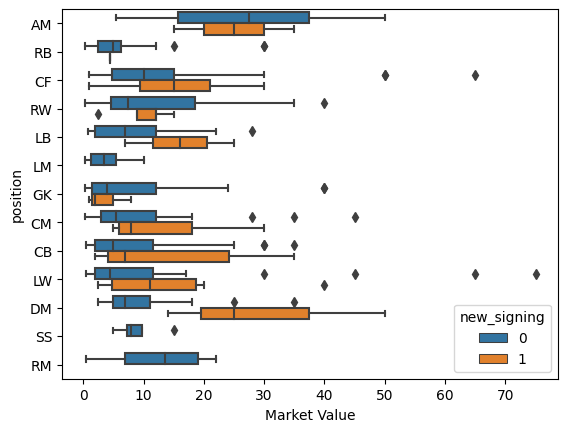

In [73]:
sns.boxplot(y='position',x='market_value',data=concat_train_data,hue='new_signing',orient='h')
plt.xlabel("Market Value")
plt.show()

<Axes: xlabel='position', ylabel='market_value'>

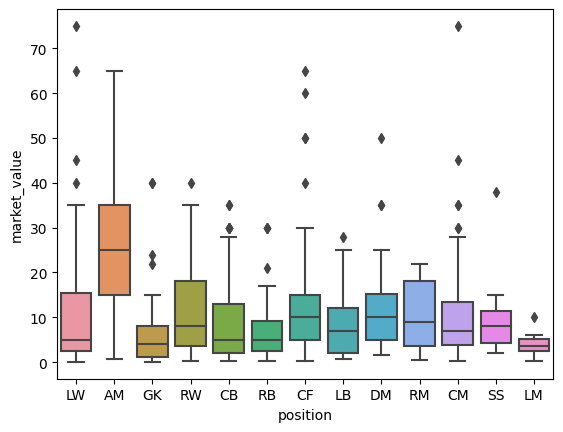

In [74]:
sns.boxplot(x='position', y='market_value', data=df)

In [75]:
encoded_data = pd.get_dummies(concat_train_data, columns=["new_foreign","big_club","new_signing"],drop_first=True)
encoded_data.head()

,name,club,age,position,position_cat,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,age_cat,club_id,market_value,new_foreign_1,big_club_1,new_signing_1
1,Mesut Ozil,Arsenal,28,AM,Attackers,4395,9.5,0.56,167,EU,Germany,4,1,50.0,0,1,0
366,Ã€ngel Rangel,Swansea,34,RB,Defenders,137,4.0,1.88,26,EU,Spain,6,16,1.0,0,0,0
260,Romelu Lukaku,Manchester+United,24,CF,Attackers,3727,11.5,4.50,221,EU,Belgium,2,12,50.0,0,1,0
3,Theo Walcott,Arsenal,28,RW,Attackers,2393,7.5,0.15,122,England,England,4,1,20.0,0,1,0
265,Juan Mata,Manchester+United,29,AM,Attackers,2280,7.0,0.35,102,EU,Spain,4,12,30.0,0,1,0


<Axes: >

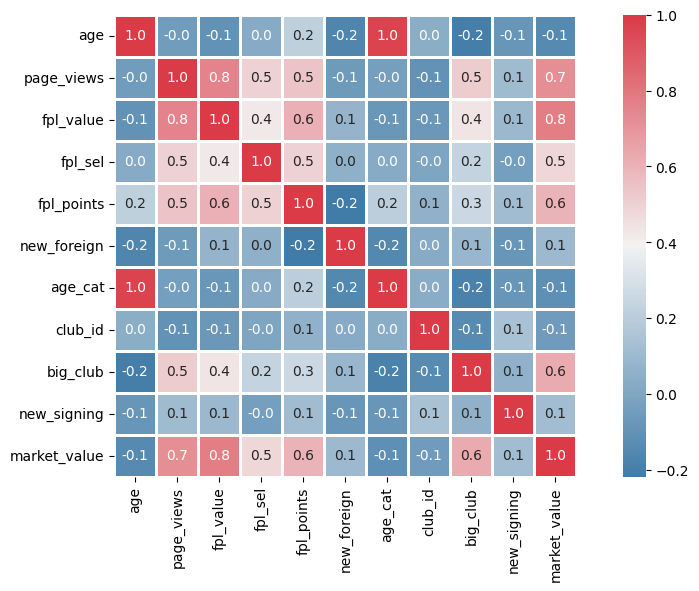

In [76]:
corr = concat_train_data.corr()
f,ax = plt.subplots(figsize=(12,6))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),linewidth=1,fmt=".1f",ax=ax, cmap=sns.diverging_palette(240,10,as_cmap=True),square=True,annot=True)

In [77]:
corr

,age,page_views,fpl_value,fpl_sel,fpl_points,new_foreign,age_cat,club_id,big_club,new_signing,market_value
age,1.000000,-0.049327,-0.099975,0.024667,0.215552,-0.164685,0.969917,0.041378,-0.205341,-0.083684,-0.144592
page_views,-0.049327,1.000000,0.755074,0.497496,0.547811,-0.058465,-0.033223,-0.101979,0.514907,0.107937,0.716096
fpl_value,-0.099975,0.755074,1.000000,0.420925,0.605196,0.075629,-0.077714,-0.071966,0.437659,0.093738,0.771985
fpl_sel,0.024667,0.497496,0.420925,1.000000,0.498251,0.049998,0.024549,-0.005185,0.229267,-0.035876,0.484164
fpl_points,0.215552,0.547811,0.605196,0.498251,1.000000,-0.218141,0.206685,0.062469,0.258834,0.111885,0.595919
new_foreign,-0.164685,-0.058465,0.075629,0.049998,-0.218141,1.000000,-0.152721,0.026559,0.082913,-0.082678,0.097173
age_cat,0.969917,-0.033223,-0.077714,0.024549,0.206685,-0.152721,1.000000,0.037607,-0.188779,-0.080978,-0.116853
club_id,0.041378,-0.101979,-0.071966,-0.005185,0.062469,0.026559,0.037607,1.000000,-0.137956,0.139128,-0.052287
big_club,-0.205341,0.514907,0.437659,0.229267,0.258834,0.082913,-0.188779,-0.137956,1.000000,0.053711,0.624354
new_signing,-0.083684,0.107937,0.093738,-0.035876,0.111885,-0.082678,-0.080978,0.139128,0.053711,1.000000,0.115376


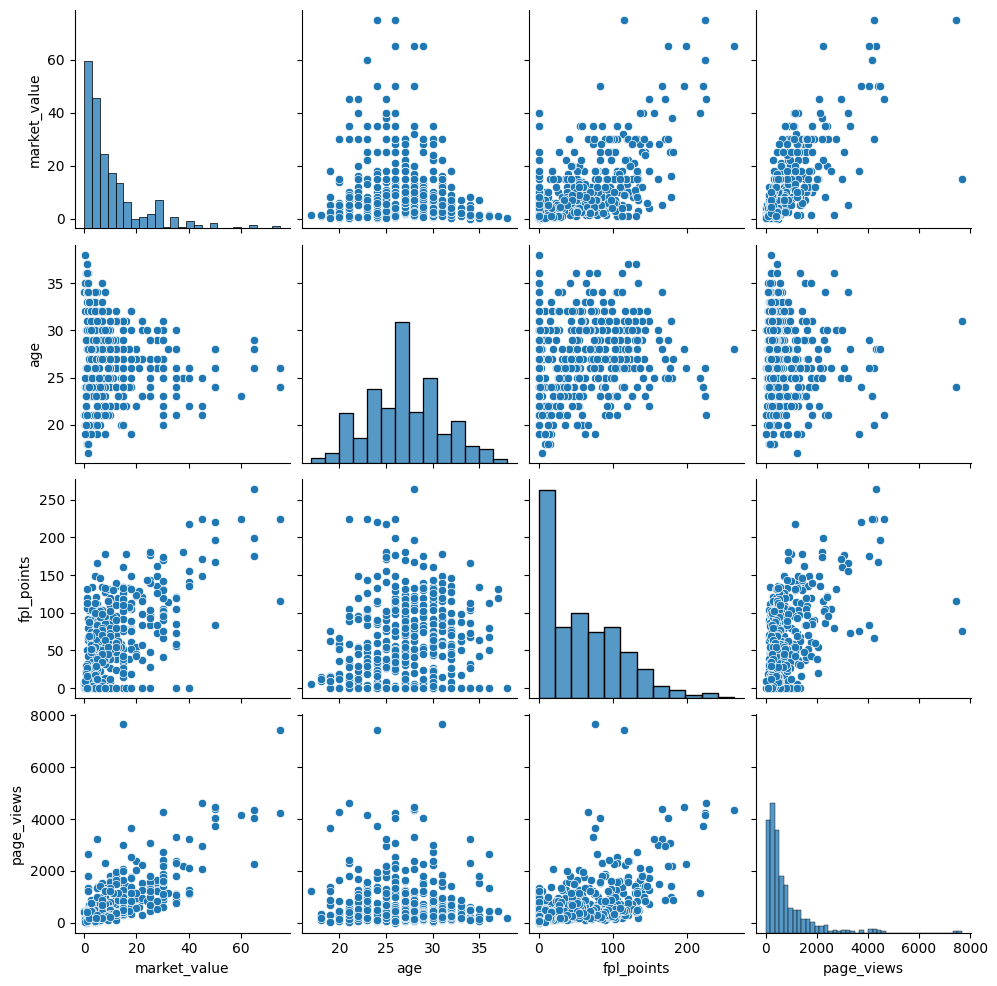

In [78]:
sns.pairplot(df, vars=['market_value', 'age', 'fpl_points', 'page_views'])

# 2. Build models using all the algorithms above to predict market_value

### Train Test Split

Since only fivecolumns are being correlated to market values, we  will take that columns only for building models

In [83]:
output_var = 'market_value'
X = encoded_data[encoded_data.columns[~encoded_data.columns.isin([output_var])]]
X = X[["page_views","fpl_value","fpl_sel","fpl_points","big_club_1"]]
y = encoded_data[[output_var]]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
x_train = x_train.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [84]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(276, 5)
(69, 5)
(276, 1)
(69, 1)


In [85]:
# performin min max scaling on input data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train[x_train.columns[~x_train.columns.isin(["big_club_1"])]])
x_test = scaler.transform(x_test[x_test.columns[~x_test.columns.isin(["big_club_1"])]])

### Linear Regression

In [43]:
# Function to calculated cross validated scores

def KFoldVerify(model, X, Y):
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    r2_scores = cross_val_score(model, X, Y, cv= cv, scoring = 'r2')
    return r2_scores.mean()

In [44]:
# Fitting a Lasso Regressor
lasso_model = Lasso(alpha=0.1, max_iter = 10000)
cross_acc_train = KFoldVerify(lasso_model, x_train, y_train)
lasso_model.fit(x_train, y_train)

acc_train = lasso_model.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = lasso_model.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

Cross Validation score - 0.5133493553254517

R^2 score of training data - 0.6124839767868681
Root Mean Square Error of training data - 6.723133904412518


### Lasso Regression

In [45]:
# Fitting a Lasso Regressor
lasso_model = Lasso(alpha=0.1, max_iter = 10000)
cross_acc_train = KFoldVerify(lasso_model, x_train, y_train)
lasso_model.fit(x_train, y_train)

acc_train = lasso_model.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = lasso_model.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

Cross Validation score - 0.5133493553254517

R^2 score of training data - 0.6124839767868681
Root Mean Square Error of training data - 6.723133904412518


### Ridge Regression

In [46]:
# Fitting a Ridge Regressor
ridge_model = Ridge(alpha=0.1,max_iter=10000)
cross_acc_train = KFoldVerify(ridge_model, x_train, y_train)
ridge_model.fit(x_train, y_train)

acc_train = ridge_model.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = ridge_model.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

Cross Validation score - 0.5021093415264315

R^2 score of training data - 0.6209264443951013
Root Mean Square Error of training data - 6.649495145049757


### Nearest Neighbour Regression

In [47]:
# fitting a nearest neighbour regressor
K_neigh = KNeighborsRegressor(n_neighbors=10, metric='minkowski')
cross_acc_train = KFoldVerify(K_neigh, x_train, y_train)
K_neigh.fit(x_train, y_train)

acc_train = K_neigh.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = K_neigh.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

Cross Validation score - 0.5047545824013188

R^2 score of training data - 0.6534327301742209
Root Mean Square Error of training data - 6.358002603133257


### Support Vector Regression

In [48]:
# fitting a support vector regressor
SVR_regr = SVR(C = 10000.0, epsilon=0.001, kernel='poly', degree=3)
cross_acc_train = KFoldVerify(SVR_regr, x_train, y_train)
SVR_regr.fit(x_train, y_train)

acc_train = SVR_regr.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = SVR_regr.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

Cross Validation score - -2.1692923166077573

R^2 score of training data - 0.5415971800507612
Root Mean Square Error of training data - 7.31224222107222


### Tree Regression

In [49]:
# fitting a Decision Tree regressor
tree_model = DecisionTreeRegressor(random_state = 0,max_depth=5)  
cross_acc_train = KFoldVerify(tree_model, x_train, y_train)
tree_model.fit(x_train, y_train)

acc_train = tree_model.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = tree_model.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

Cross Validation score - 0.44133528427801477

R^2 score of training data - 0.8380095124027956
Root Mean Square Error of training data - 4.346820285891395


### Random Forest Regression

In [50]:
# fitting a random forest regressor
Forest_regr = RandomForestRegressor(max_depth=5, random_state=0)
cross_acc_train = KFoldVerify(Forest_regr, x_train, y_train)
Forest_regr.fit(x_train, y_train)

acc_train = Forest_regr.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = Forest_regr.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

Cross Validation score - 0.5790506768143497

R^2 score of training data - 0.8547337302184805
Root Mean Square Error of training data - 4.116321819801863


### Gradient Boosted Regression

In [51]:
params = {'n_estimators': 300,'max_depth': 2,
          'min_samples_split': 9,'learning_rate': 0.1}
gbr_model = GradientBoostingRegressor(**params)
cross_acc_train = KFoldVerify(gbr_model, x_train, y_train)
gbr_model.fit(x_train, y_train)

acc_train = gbr_model.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = gbr_model.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\naman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\naman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "c:\Users\naman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\naman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of GradientBoostingRegressor must be a str among {'squared_error', 'absolute_error', 'huber', 'quantile'}. Got 'ls' instead.


# 3. Tune the hyperparameters and build the most accurate model

>Grid Search is an effective method for adjusting the parameters in supervised learning and improve the generalization performance of a model. With Grid Search, we try all possible combinations of the parameters of interest and find the best ones.

### Linear Regression

In [ ]:
# Fitting a Lasso Regressor
lasso_model = Lasso(alpha=0.1, max_iter = 10000)
cross_acc_train = KFoldVerify(lasso_model, x_train, y_train)
lasso_model.fit(x_train, y_train)

acc_train = lasso_model.score(x_train, y_train)
print("Cross Validation score - " + str(cross_acc_train))
print()


train_pred = lasso_model.predict(x_train)
mse_train = mean_squared_error(y_train,train_pred)
print("R^2 score of training data - " + str(acc_train))
print("Root Mean Square Error of training data - " + str(mse_train**(0.5)))

Cross Validation score - 0.723501093152916

R^2 score of training data - 0.7831247681331146
Root Mean Square Error of training data - 5.547443018735516


### Lasso Regression

In [ ]:
# For Lasso Regression
params = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lasso_reg = GridSearchCV(Lasso(), param_grid = params, cv = 5, scoring = 'r2')
lasso_reg.fit(x_train, y_train)
acc_train = lasso_reg.score(x_train, y_train)

print("Cross Validation score - " + str(lasso_reg.best_score_))
print()

print("R^2 score of training data - " + str(acc_train))
print()

print(lasso_reg.best_estimator_)
lasso_best_params = lasso_reg.best_params_

Cross Validation score - 0.7542155221742477

R^2 score of training data - 0.8134386273327976

Lasso(alpha=0.01)


### Ridge Regression

In [ ]:
# For Ridge Regression
params = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_reg = GridSearchCV(Ridge(), param_grid = params, cv = 5, scoring = 'r2')
ridge_reg.fit(x_train, y_train)
acc_train = ridge_reg.score(x_train, y_train)

print("Cross Validation score - " + str(ridge_reg.best_score_))
print()

print("R^2 score of training data - " + str(acc_train))
print()

print(ridge_reg.best_estimator_)
ridge_best_params = ridge_reg.best_params_

Cross Validation score - 0.749679212033698

R^2 score of training data - 0.8093717370776707

Ridge(alpha=1)


### Nearest Neighbour Regression

In [ ]:
# For Nearest Neighbour Regression
params = {'n_neighbors': [4,5,6,7,8,9,10,11,12,13,14,15], 'weights': ['uniform', 'distance']}

knn_reg = GridSearchCV(KNeighborsRegressor(),param_grid = params, scoring = 'r2', cv = 5)
knn_reg.fit(x_train,y_train)

acc_train = knn_reg.score(x_train, y_train)

print("Cross Validation score - " + str(knn_reg.best_score_))
print()

print("R^2 score of training data - " + str(acc_train))
print()

print(knn_reg.best_estimator_)
knn_best_params = knn_reg.best_params_

Cross Validation score - 0.5641789645310735

R^2 score of training data - 1.0

KNeighborsRegressor(n_neighbors=8, weights='distance')


### Support Vector Regression

In [ ]:
# For Support Vector Regression
params = [{'C': [1,10,100,1000,10000], 'epsilon': [0.0001,0.001,0.01,0.1,1],
          'kernel': ['poly'], 'degree':[2,3,4]},
          {'C': [1,10,100,1000,10000], 'epsilon': [0.0001,0.001,0.01,0.1,1],
          'kernel': ['rbf']}]

svr_reg = GridSearchCV(SVR(),param_grid = params, scoring = 'r2', cv = 5)
svr_reg.fit(x_train,y_train)

acc_train = svr_reg.score(x_train, y_train)

print("Cross Validation score - " + str(svr_reg.best_score_))
print()

print("R^2 score of training data - " + str(acc_train))
print()

print(svr_reg.best_estimator_)
svr_best_params = svr_reg.best_params_

Cross Validation score - 0.7209910859664762

R^2 score of training data - 0.9839912498602029

SVR(C=100, epsilon=1)


### Tree Regression

In [ ]:
# For Decision Tree Regression
params  = {'splitter': ['best', 'random'],'min_samples_leaf': [1, 2 ,3],
           'max_depth': [6,8,10,12,14,16,18]}

tree_reg = GridSearchCV(DecisionTreeRegressor(random_state = 0) ,param_grid = params, scoring = 'r2', cv = 5)
tree_reg.fit(x_train,y_train)

acc_train = tree_reg.score(x_train, y_train)

print("Cross Validation score - " + str(tree_reg.best_score_))
print()

print("R^2 score of training data - " + str(acc_train))
print()

print(tree_reg.best_estimator_)
tree_best_params = tree_reg.best_params_

Cross Validation score - 0.6434284231065563

R^2 score of training data - 0.8443575684697755

DecisionTreeRegressor(max_depth=6, min_samples_leaf=3, random_state=0,
                      splitter='random')


### Random Forest Regression

In [ ]:
# For Random Forest Regression
params = {
    'bootstrap': [True],
    'max_depth': [8, 10, 12, 14, 16],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [40, 50, 60, 70],
    'max_features': [0.3, 0.4, 0.5]
}

forest_reg = GridSearchCV(RandomForestRegressor(), param_grid = params, scoring = 'r2', cv = 5)
forest_reg.fit(x_train,y_train)
acc_train = forest_reg.score(x_train, y_train)

print("Cross Validation score - " + str(forest_reg.best_score_))
print()

print("R^2 score of training data - " + str(acc_train))
print()
print(forest_reg.best_estimator_)
forest_best_params = forest_reg.best_params_

Cross Validation score - 0.7823960265715112

R^2 score of training data - 0.9694378128636764

RandomForestRegressor(max_depth=12, max_features=0.4, n_estimators=60)


### Gradient Boosted Regression

In [ ]:
# For Gradient Boosted Regression
params = {'n_estimators': [50, 100, 200, 300],
          'max_depth': [8,10,12,14,16],
          'min_samples_split': [1,2,3],
          'subsample':[0.1, 0.2]}

gb_reg = GridSearchCV(GradientBoostingRegressor() ,param_grid = params, scoring = 'r2', cv = 5)
gb_reg.fit(x_train,y_train)

acc_train = gb_reg.score(x_train, y_train)

print("Cross Validation score - " + str(gb_reg.best_score_))
print()

print("R^2 score of training data - " + str(acc_train))
print()

print(gb_reg.best_estimator_)
gb_best_params = gb_reg.best_params_

Cross Validation score - 0.7835868815077942

R^2 score of training data - 0.9916977074040858

GradientBoostingRegressor(max_depth=8, min_samples_split=3, n_estimators=200,
                          subsample=0.2)


# 4. Use model selection approaches discussed in class to choose the best model